# JAX features

This notebook demonstrates the jax features of spotter, which greatly accelerate the computation of light curves and their amplitudes.

## The JAX methods
Let's create a star and add two spots

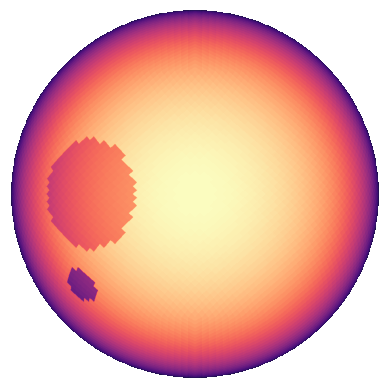

In [1]:
from spotter import Star
import numpy as np

star = Star(u=[0.3, 0.2], N=2**5)
star.add_spot(np.pi / 3, np.pi / 4, 0.1, 0.2)
star.add_spot(np.pi / 2, np.pi / 5, 0.3, 0.1)
star.show()

Using JAX, we can compile the computation of the light curve

In [2]:
phase = np.linspace(0, 2 * np.pi, 200)
flux = star.jax_flux(phase)

where `flux` will be a function of the *healpix* pixels values, such as

In [3]:
flux(star.map_spot)

Array([0.99363626, 0.99360753, 0.9935608 , 0.99351675, 0.99347564,
       0.9934374 , 0.99340172, 0.9933686 , 0.99333835, 0.9933105 ,
       0.99328503, 0.99326207, 0.99324156, 0.99322329, 0.9932072 ,
       0.99319366, 0.99318223, 0.99317289, 0.99316584, 0.99316104,
       0.99315827, 0.99315756, 0.99315927, 0.99316302, 0.99316882,
       0.99317687, 0.9931873 , 0.99319978, 0.99321443, 0.99323163,
       0.99325106, 0.99327274, 0.99329697, 0.99332373, 0.99335289,
       0.99338456, 0.99341911, 0.99345627, 0.99349606, 0.9935388 ,
       0.99358449, 0.99363301, 0.99368448, 0.99373927, 0.99379707,
       0.99385798, 0.99392227, 0.99398987, 0.99406078, 0.994135  ,
       0.99421302, 0.99429408, 0.9943788 , 0.99446712, 0.994559  ,
       0.99465439, 0.99475327, 0.99485591, 0.99496201, 0.99507156,
       0.99518471, 0.99534223, 0.99553116, 0.99584352, 0.99607948,
       0.99632178, 0.99654946, 0.99692758, 0.99715455, 0.99738651,
       0.99776786, 0.99799644, 0.99824879, 0.99850283, 0.99899

This way, the fluxes of a large number of maps can be computed more efficiently. Let's benchmark the standard implementation against the jax implementation:

In [4]:
# standard
%timeit star.flux(phase)

92.1 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
# jax
# note here the change of argument

import jax
%timeit jax.block_until_ready(flux(star.map_spot))

1.23 ms ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In this case, we note a huge 
speedup. For convenience, we define the `jax_amplitude` method that computes the peak to peak amplitude of the variability with a resolution being relative to that of the map (accessible as `star.resolution`), i.e.

In [6]:
# resolution is 2 times that of a pixel element
amplitude = star.jax_amplitude(resolution=2)

amplitude(star.map_spot)

Array(0.00684219, dtype=float64)

## Non-useful case study

As a case study, let try to derive the relation between number of spots and amplitude for a stellar surface covered by spots with fixed radii amd contrast, and given a certain spot distribution.

Here is an example of such star:

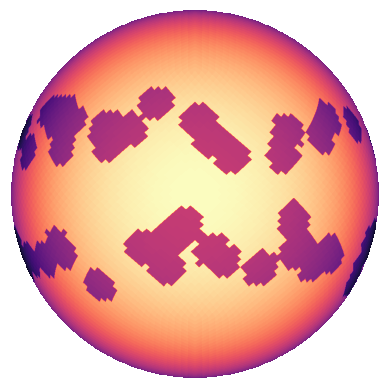

In [7]:
import numpy as np
from spotter import Star, butterfly

star = Star(u=[0.3, 0.2], N=2**5)
angles = butterfly(np.deg2rad(20), np.deg2rad(5), 100)
star.add_spot(*angles, 0.1, 0.3)
star.show()

We can run this random draw of spots 500 times and record the amplitude variation, all relatively efficiently using the JAX methods

In [8]:
draws = 500
max_spots = 500

amplitudes = np.zeros((draws, max_spots))
amplitude_function = star.jax_amplitude(resolution=5)

for i in range(draws):
    # clearing the stellar surface
    star.clear_surface()
    for j in range(max_spots):
        # adding random spot one at a time
        angles = butterfly(np.deg2rad(20), np.deg2rad(5), 1)
        star.add_spot(*angles, 0.1, 0.2)
        # recording amplitudes
        amplitudes[i, j] = amplitude_function(star.map_spot)

Let see the result

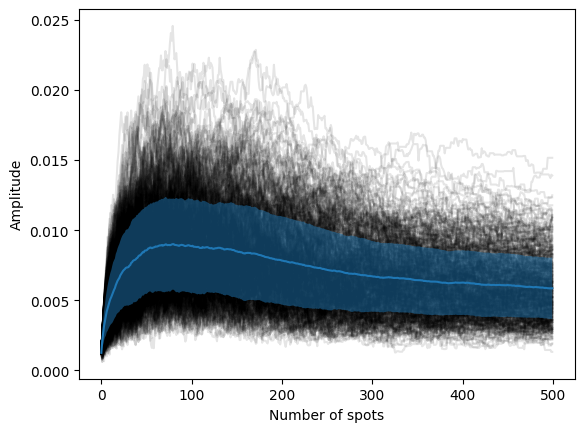

In [9]:
import matplotlib.pyplot as plt

mean, std = np.mean(amplitudes, axis=0), np.std(amplitudes, axis=0)

for i in range(draws):
    plt.plot(amplitudes[i, :], c="k", alpha=0.1, zorder=0)

plt.fill_between(np.arange(max_spots), mean - std, mean + std, alpha=0.5, zorder=1)
plt.plot(mean, zorder=2)
plt.xlabel("Number of spots")
_ = plt.ylabel("Amplitude")

That's it, not sure how useful but that demonstrates the kind of statistics that can be done as an ensemble.

The thing to note here is the trade-offs involved in the resolution of the phase grid used to compute the amplitude, and the resolution of the healpix map itself.